# EP1 - Mandelbrot set
###### Notebook baseado no dos miniEPs

Preencha o nome dos 5 membros do seu grupo na tabela abaixo:

| Nome | NUSP |
|------|------|
| Caio Andrade | 9797232 |
| Caio Fontes | 10692061 |
| Eduardo Laurentino | 8988212 |
| Thiago Teixeira | 10736987 |
| Washington Meireles | 10737157 |

## Tarefa 3 - Apresentação dos resultados

### Funções para compilar/Rodar os testes:

In [1]:
;make 

gcc -o mandelbrot_omp -std=c11 -lm -fopenmp mandelbrot_omp.c
gcc -o mandelbrot_pth -std=c11 -lm -pthread mandelbrot_pth.c
gcc -o mandelbrot_seq -std=c11 -lm mandelbrot_seq.c


In [2]:
;./mandelbrot_seq

usage: ./mandelbrot_seq c_x_min c_x_max c_y_min c_y_max image_size
examples with image_size = 11500:
    Full Picture:         ./mandelbrot_seq -2.5 1.5 -2.0 2.0 11500
    Seahorse Valley:      ./mandelbrot_seq -0.8 -0.7 0.05 0.15 11500
    Elephant Valley:      ./mandelbrot_seq 0.175 0.375 -0.1 0.1 11500
    Triple Spiral Valley: ./mandelbrot_seq -0.188 -0.012 0.554 0.754 11500


In [3]:
;./mandelbrot_pth

usage: ./mandelbrot_pth c_x_min c_x_max c_y_min c_y_max image_size n_threads
examples with image_size = 11500:
    Full Picture:         ./mandelbrot_pth -2.5 1.5 -2.0 2.0 11500
    Seahorse Valley:      ./mandelbrot_pth -0.8 -0.7 0.05 0.15 11500
    Elephant Valley:      ./mandelbrot_pth 0.175 0.375 -0.1 0.1 11500
    Triple Spiral Valley: ./mandelbrot_pth -0.188 -0.012 0.554 0.754 11500


In [4]:
;./mandelbrot_omp

usage: ./mandelbrot_omp c_x_min c_x_max c_y_min c_y_max image_size num_threads
examples with image_size = 11500:
    Full Picture:         ./mandelbrot_omp -2.5 1.5 -2.0 2.0 11500 4
    Seahorse Valley:      ./mandelbrot_omp -0.8 -0.7 0.05 0.15 11500 4
    Elephant Valley:      ./mandelbrot_omp 0.175 0.375 -0.1 0.1 11500 4
    Triple Spiral Valley: ./mandelbrot_omp -0.188 -0.012 0.554 0.754 11500 4


In [5]:
using DataFrames, Query, StatsPlots, Statistics

function measure_mandelbrot(size, f, method; threads = 0)
    if f==0 param = "-2.5 1.5 -2.0 2.0 11500" #Full Picture
    elseif f==1 param = "-0.8 -0.7 0.05 0.15 11500" #Seahorse Valley
    elseif f==2 param = "0.175 0.375 -0.1 0.1 11500" #Elephant Valley
    elseif f==3 param = "-0.188 -0.012 0.554 0.754 11500" #Triple Spiral Valley
    end
                
    if threads == 0
        results = parse.(Float64, read("./$method $param $size", String))
    else
        results = parse.(Float64, read("./$method $param $size $threads", String))
    end 
    return DataFrame(size = size,
        f = f,
        threads = threads,
        duration = results[1])
end

measure_mandelbrot (generic function with 1 method)

A função `run_experiments` recebe os mesmos parâmetros `size`, `f`, `method` e `threads`, e um parâmetro adicional `repetitions`, com o número de repetições de cada experimento com um dado número de `threads`. A função devolve um `DataFrame` com todos os experimentos.

In [12]:
function run_experiments(size, f, method, repetitions; threads = [])
    run(`make`)
    
    results = DataFrame(size = Int[],
        f = Int[],
        threads = Int[],
        duration = Float64[])  
    
    if threads == []
        for r in 1:repetitions
            for s in size
                append!(results,
                    measure_mandelbrot(s, f, method))    
            end
        end
    else
        for t 
    
    return results
end

run_experiments (generic function with 1 method)

A função `parse_results` recebe um `DataFrame` de resultados, produzido pela função `run_experiments`, e um parâmetro `target_integral`, com o valor da integral a estimar. A função devolve um `DataFrame` com a média e o intervalo de confiança da média a 95% das estimativas e dos tempos de execução, agrupados por número de threads.

In [13]:
function parse_results(results, target_integral)
    parsed_results = results |>
                    @groupby(_.threads) |>
                    @map({threads = key(_),
                          mean_estimate = mean(_.estimate),
                          ci_estimate = 1.96 * std(_.estimate),
                          mean_duration = mean(_.duration),
                          ci_duration = 1.96 * std(_.duration),
                          target = target_integral}) |>
                    DataFrame
    
    return parsed_results
end

parse_results (generic function with 1 method)

### Exercício 3a)

Realize os experimentos em sua máquina rodando a célula abaixo. Ajuste os valores para a sua máquina. **Não faça menos de 5 repetições**.

In [14]:
size = 20000000
f = 0
threads = 1:256
repetitions = 5

results = run_experiments(size, f, threads, repetitions)
parsed_results = parse_results(results, pi)

gcc monte_carlo.c -o monte_carlo -Wall -lpthread -lm


monte_carlo.c: In function ‘monte_carlo_integrate_thread’:
monte_carlo.c:142:18: warning: cast to pointer from integer of different size [-Wint-to-pointer-cast]
  142 |     pthread_exit((void *)task_id);
      |                  ^


,threads,mean_estimate,ci_estimate,mean_duration,ci_duration,target
,Int64,Float64,Float64,Float64,Float64,Irration…
1,1,3.14209,0.00385266,1.03595,0.271623,π
2,2,3.14184,0.000833919,0.873232,0.05983,π
3,3,3.14132,0.00308427,0.850018,0.0541103,π
4,4,3.1409,0.00275526,0.797031,0.16875,π
5,5,3.14187,0.00208175,0.713616,0.0738909,π
6,6,3.14133,0.00154033,0.707242,0.0560859,π
7,7,Inf,NaN,0.717297,0.261481,π
8,8,3.14276,0.000774302,0.718588,0.121921,π
9,9,3.1419,0.00175286,0.690047,0.0851627,π


Agora, escreva uma função **em Julia** chamada `save_csv_results`, que recebe um `DataFrame` e um nome de arquivo, e escreve o `DataFrame` em disco, no formato `.csv`, com o nome passado no argumento.

Utilize a biblioteca [CSV](https://juliadata.github.io/CSV.jl/stable/), já instalada no ambiente deste notebook.

In [15]:
using CSV

function save_csv_results(parsed_results, name)
    CSV.write(string(name, ".csv"), parsed_results)
end

save_csv_results (generic function with 1 method)

In [16]:
save_csv_results(parsed_results, "teste")

"teste.csv"

Escreva uma função **em Julia** chamada `read_csv_results`, que recebe um nome de arquivo e lê o arquivo correspondente, devolvendo um `DataFrame`.

In [17]:
function read_csv_results(filename)
    return CSV.read(filename)
end

read_csv_results (generic function with 1 method)

In [18]:
read_csv_results("teste.csv")

,threads,mean_estimate,ci_estimate,mean_duration,ci_duration,target
,Int64,Float64,Float64,Float64,Float64,String
1,1,3.14209,0.00385266,1.03595,0.271623,π
2,2,3.14184,0.000833919,0.873232,0.05983,π
3,3,3.14132,0.00308427,0.850018,0.0541103,π
4,4,3.1409,0.00275526,0.797031,0.16875,π
5,5,3.14187,0.00208175,0.713616,0.0738909,π
6,6,3.14133,0.00154033,0.707242,0.0560859,π
7,7,Inf,NaN,0.717297,0.261481,π
8,8,3.14276,0.000774302,0.718588,0.121921,π
9,9,3.1419,0.00175286,0.690047,0.0851627,π


Salve o DataFrame `results` em disco. **Vocês devem entregar o .csv também**.

### Exercício 3b)

Como vocês já se familiarizaram um pouco com funções para geração de gráficos no miniEP1&2, explique o que faz a função `plot_results` abaixo. Ela é uma generalização das funções usadas no miniEP anterior. Para ajudar, você pode modificar e usar as chamadas de função no **Exercício 3c)**.

### RESPOSTA:

A função `plot_results()` abaixo possui 6 possíveis parâmetros: 

- **'x'**: coluna do DataFrame que será o eixo coordenado do gráfico (o número de threads em cada experimento, no nosso caso);
- **'y'**: coluna do DataFrame que será o eixo ordenado do gráfico e cujos valores serão plotados em forma de pontos ao longo do eixo coordenado;
- **'target_label'** e **'hline'**: quando presentes na chamada da função, indicam o resultado analítico do valor exato da integral definida que estimamos via Monte Carlo (pi, no nosso caso) - o segundo sendo um vetor com os pontos da coluna do DataFrame que representam tal valor e serão plotados em forma de linha horizontal tracejada, e o primeiro funcionando como rótulo explicativo sobre tal linha na legenda;
- **'series_label'**: um rótulo para a legenda do gráfico que indica o significado dos pontos plotados (ou seja, significado dos valores no eixo ordenado) e, quando presente, do intervalo de erro associado aos respectivos pontos (no nosso caso, o intervalo de confiança a 95%).
- **'yerror'**: quando presente na chamada da função, indica a coluna no DataFrame cujos valores representam a amplitude do intervalo de confiança associado ao valores médios plotados em forma de pontos.
    

Tendo esses parâmetros em mente, é facil notar que a função consiste apenas de condicionais para verificar se o gráfico a ser produzido terá a representação do intervalo de confiança e linha objetivo. Caso satisfeitas, tais condicionais geram as respectivas entidades, e caso contrário geram apenas um gráfico com os pontos do DataFrame usando `alpha`(transparência dos pontos) = 0.6 e os labels passados na chamada da função.

---

In [19]:
function plot_results(x, y, target_label, series_label; hline = [], yerror = [])      
    if yerror != []
        p = scatter(x,        
            y,
            yerror = yerror,
            alpha = 0.6,
            labels = series_label,
            legend = :topleft)
    else
        p = scatter(x,        
            y,
            alpha = 0.6,
            labels = series_label,
            legend = :topleft)
    end
    
    if hline != []
        plot!(x,        
            hline,
            labels = target_label,                 
            line = :dash,        
            width = 2.0)
    end
    
    return p
end


plot_results (generic function with 1 method)

### Exercício 3c)

1. Rode as células na seção abaixo e gere os gráficos. **Entregue o notebook com os gráficos gerados**.
2. Descreva o comportamento do tempo de execução conforme aumentamos o número de threads, em termos da média e do intervalo de confiança. Nos próximos EPs, vamos aprender a fazer uma *regressão linear* que explique os dados observados usando *coeficientes*.
3. Por que você acha que o tempo de execução aumenta conforme aumentamos as threads? Era isso que você esperava?

Responda na célula abaixo:

### RESPOSTAS:

**1)** *Gráficos abaixo*

**2)** A duração média do tempo de execução começa relativamente alta quando executamos o programa com apenas 1 thread, mas logo decai para um patamar consideravelmente mais baixo. Embora haja alguns pontos consideravelmente acima desse patamar que valem ser mencionados, em geral a média da duração permanece nesse patamar baixo para execuções com até aproximadamente 150 threads, intervalo no qual também consistentemente obtivemos (salvo alguns exeções) intervalos de confiança com amplitudes bastante pequenas, denotando que a variância das durações das execuções nesse intervalo de número de threads foi bastante baixo.

Entretanto, à partir do momento que o número de threads ultrapassa o de 150 e, mais acentuadamente à partir de execuções com aproximadamente 160 threads ou mais, não só a duração média volta a crescer, atingindo inclusive valores consideravelmente mais altos dos que os inicialmente observados, como também aumenta a amplitude dos respectivos intervalos de confiança, indicando que nessas execuções a variância das durações aumentou consideravel e consistentemente. 

**3)** Acreditamos que a razão dessa alta no tempo de execução se deve ao limite de Core´s, capacidade de processamento do computador e limitações de memória. Isso já que até certa quantidade, a divisão de tarefas entre as threads se mostra efetiva e realmente torna o programa consistentemente mais rápido, porém, ao atingir certa quantidade de threads, o escalonamento extenso, a sobrecarga associada a administração de tantas threads e a grande quantidade de threads em relação aos Core´s acabam gerando bottlenecks e travamentos devido à competição de recursos, que levam ao aumento e maior insconsitência no tempo de execução.

---

#### Gerando Gráficos

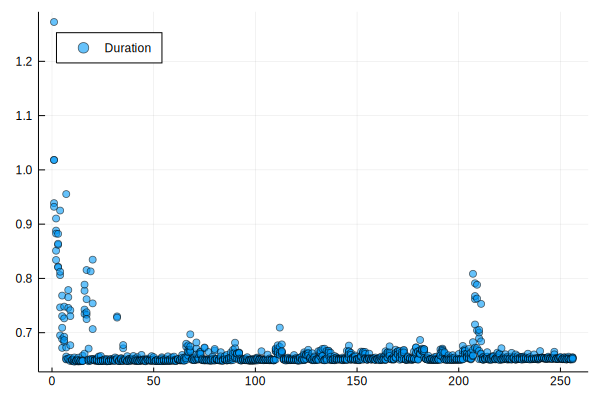

In [20]:
plot_results(results.threads,
    results.duration,    
    "pi",
    "Duration")

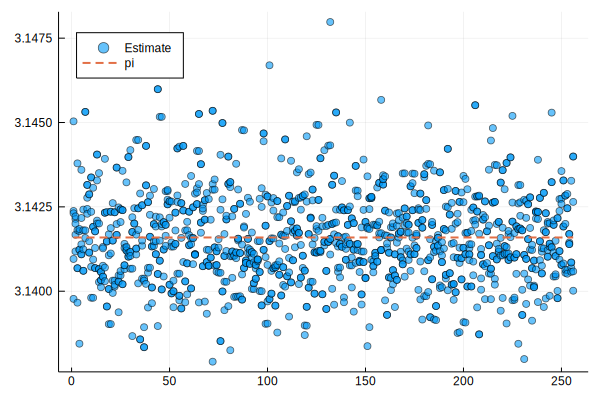

In [21]:
plot_results(results.threads,
    results.estimate,    
    "pi",
    "Estimate",
    hline = [pi for i in 1:nrow(results)])

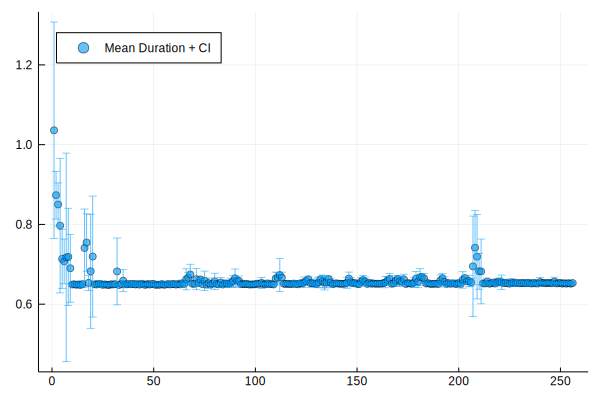

In [22]:
plot_results(parsed_results.threads,
    parsed_results.mean_duration,
    "pi",
    "Mean Duration + CI",
    yerror = parsed_results.ci_duration)

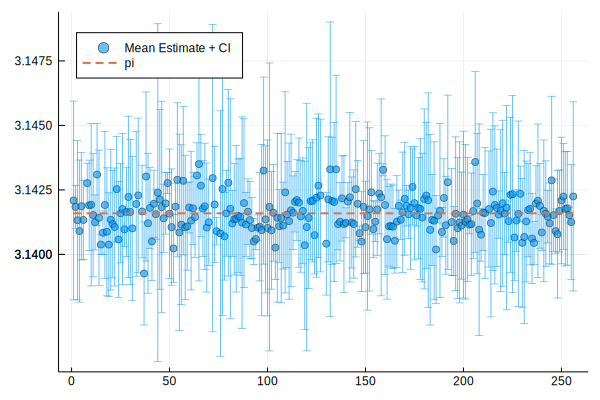

In [23]:
plot_results(parsed_results.threads,
    parsed_results.mean_estimate,
    "pi",
    "Mean Estimate + CI",
    hline = [pi for i in 1:nrow(parsed_results)],
    yerror = parsed_results.ci_estimate)